In [159]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

In [160]:
df = pd.read_csv("pokemon_data.csv", index_col = "Name")


In [161]:
df['Smash Scaled'] = (df['Smashes'] - df['Smashes'].min()) / (df['Smashes'].max() - df['Smashes'].min())
df['Pass Scaled'] = (df['Passes'] - df['Passes'].min()) / (df['Passes'].max() - df['Passes'].min())


# Ensure Total = 1 for each row
df['Total'] = df['Smash Scaled'] + df['Pass Scaled']
df['Pass Normalized'] = df['Pass Scaled'] / df['Total']
df['Smash Normalized'] = df['Smash Scaled'] / df['Total']

df['filename'] = df.index + '.png'  # Example: Pikachu -> Pikachu.jpg
df['Smash Normalized'] = df['Smash Normalized'] *10

In [162]:
df.head()

,Passes,Smashes,Smash Scaled,Pass Scaled,Total,Pass Normalized,Smash Normalized,filename
Name,,,,,,,,
Bulbasaur,1187934,331851,0.408613,1.000000,1.408613,0.709918,2.900818,Bulbasaur.png
Ivysaur,1172763,303853,0.373735,0.987044,1.360779,0.725352,2.746478,Ivysaur.png
Venusaur,1175757,273495,0.335917,0.989601,1.325518,0.746577,2.534232,Venusaur.png
Charmander,1152826,271930,0.333967,0.970017,1.303985,0.743887,2.561130,Charmander.png
Charmeleon,1135715,275524,0.338445,0.955404,1.293849,0.738420,2.615797,Charmeleon.png


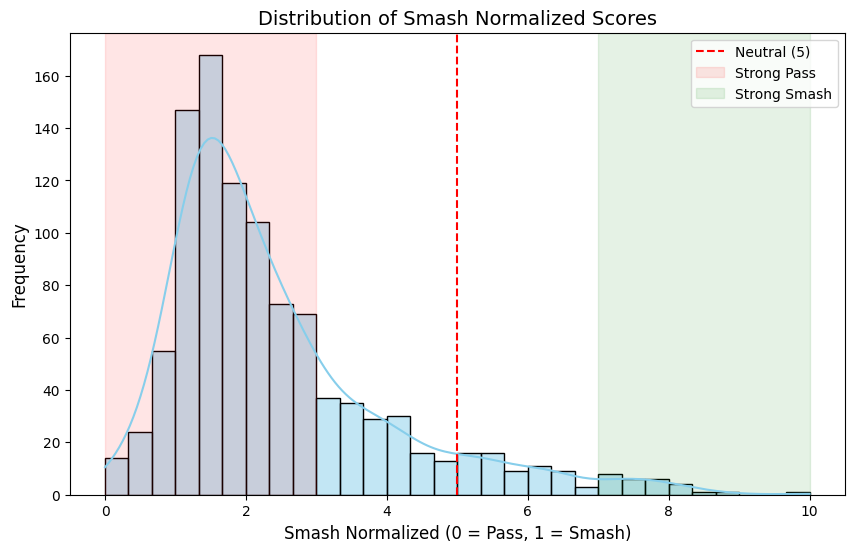

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
ax = sns.histplot(df['Smash Normalized'], kde=True, bins=30, color='skyblue', edgecolor='black')

# Highlight key regions
ax.axvline(5, color='red', linestyle='--', label='Neutral (5)')
ax.axvspan(0, 3, color='red', alpha=0.1, label='Strong Pass')
ax.axvspan(7, 10, color='green', alpha=0.1, label='Strong Smash')

plt.title("Distribution of Smash Normalized Scores", fontsize=14)
plt.xlabel("Smash Normalized (0 = Pass, 1 = Smash)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.show()

# Oversampling

In [164]:
low_mask = df['Smash Normalized'] <= 4.0
mid_mask = (df['Smash Normalized'] > 4.0) & (df['Smash Normalized'] <= 7.0)
high_mask = df['Smash Normalized'] > 7.0

low_df = df[low_mask]
mid_df = df[mid_mask]
high_df = df[high_mask]


In [165]:
# Choose how many samples you want for balance
target_count = min(len(low_df), len(mid_df))

# Sample with replacement from high-score examples
oversampled_high = high_df.sample(n=target_count, replace=True, random_state=42)


In [166]:
resampled_df = pd.concat([low_df, mid_df, oversampled_high])
resampled_df = resampled_df.sample(frac=1.0, random_state=42)  # Shuffle


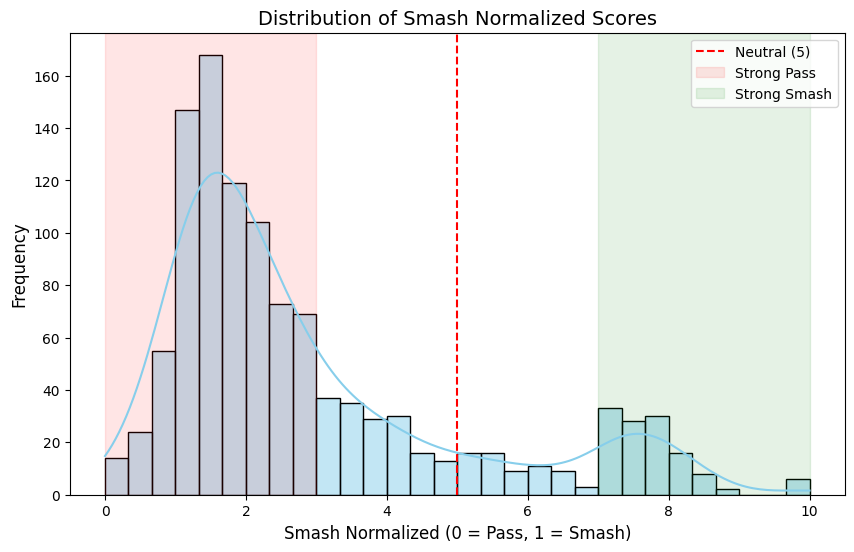

In [167]:
plt.figure(figsize=(10, 6))
ax = sns.histplot(resampled_df['Smash Normalized'], kde=True, bins=30, color='skyblue', edgecolor='black')

# Highlight key regions
ax.axvline(5, color='red', linestyle='--', label='Neutral (5)')
ax.axvspan(0, 3, color='red', alpha=0.1, label='Strong Pass')
ax.axvspan(7, 10, color='green', alpha=0.1, label='Strong Smash')

plt.title("Distribution of Smash Normalized Scores", fontsize=14)
plt.xlabel("Smash Normalized (0 = Pass, 1 = Smash)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.show()

In [168]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# Raw arrays from your DataFrame
paths = resampled_df['filename'].values  # Image paths
labels = resampled_df['Smash Normalized'].values  

# Split into train and validation sets
train_paths, val_paths, train_labels, val_labels = train_test_split(
    paths, labels, test_size=0.2, random_state=42
)


def process_path(file_path, label):
    full_path = tf.strings.join(["images/", file_path])  # Assuming the 'images/' folder
    image_bytes = tf.io.read_file(full_path)
    image = tf.image.decode_image(image_bytes, channels=0, expand_animations=False)

    # If the image has an alpha channel (shape[-1] == 4), remove transparency
    def remove_alpha(img):
        rgb, alpha = img[:, :, :3], img[:, :, 3:]
        white_bg = tf.ones_like(rgb, dtype=tf.float32) * 255  # Cast white background to float32
        alpha = tf.cast(alpha, tf.float32) / 255.0  # Normalize alpha channel
        rgb = tf.cast(rgb, tf.float32)  # Ensure rgb is also float32

        # Blend with white where alpha < 1
        blended = rgb * alpha + white_bg * (1 - alpha)
        return tf.cast(blended, tf.uint8)

    image = tf.cond(
        tf.equal(tf.shape(image)[-1], 4),  # Check if the image has an alpha channel
        lambda: remove_alpha(image),
        lambda: image
    )

    image = tf.image.resize(image, [224, 224])  # Resize the image to the expected input size (224x224)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to [0, 1]

    return image, label



def augment_high_scores(image, label):
    def apply_augmentations(img):
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_brightness(img, 0.2)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        return tf.clip_by_value(img, 0, 1)
    
    return tf.cond(
        label > 0.7,  # Use normalized threshold (0-1)
        lambda: (apply_augmentations(image), label),
        lambda: (image, label)
    )


# Create datasets with augmentation
def create_dataset(paths, labels, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    if augment:
        ds = ds.map(augment_high_scores, num_parallel_calls=tf.data.AUTOTUNE)
    return ds.shuffle(1024).batch(64).prefetch(tf.data.AUTOTUNE)


# Create training and validation datasets
train_ds = create_dataset(train_paths, train_labels, augment=True)
val_ds = create_dataset(val_paths, val_labels)

# Model definition
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)



base_model.trainable = False
# Optionally freeze early layers to avoid overfitting and speed up training
# for layer in base_model.layers[:100]:  # adjust index as needed
#     layer.trainable = False


model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])


def weighted_huber(y_true, y_pred, delta=2.0):
    error = y_true - y_pred
    weights = 1.0 + 0.5 * y_true  # lighter scaling
    condition = tf.abs(error) < delta
    squared_loss = 0.5 * tf.square(error)
    linear_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.reduce_mean(weights * tf.where(condition, squared_loss, linear_loss))



lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=200,      # Start decaying just before the wobble
    decay_rate=0.8        # A bit more aggressive decay
)



def custom_accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.abs(y_true - y_pred) < 0.5, tf.float32))

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=weighted_huber,
   metrics=[
        'mae',
        tf.keras.metrics.RootMeanSquaredError(),
        custom_accuracy  # <- your regression "accuracy"
    ]
)


# Training with early stopping
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)
# Train the model



Epoch 1/25
14/14 [==============================] - 14s 655ms/step - loss: 11.8621 - mae: 2.1130 - root_mean_squared_error: 2.6637 - custom_accuracy: 0.1529 - val_loss: 8.1358 - val_mae: 1.6103 - val_root_mean_squared_error: 1.9186 - val_custom_accuracy: 0.1250
Epoch 2/25
14/14 [==============================] - 10s 580ms/step - loss: 8.8503 - mae: 1.6152 - root_mean_squared_error: 2.0476 - custom_accuracy: 0.2042 - val_loss: 7.1647 - val_mae: 1.1523 - val_root_mean_squared_error: 1.5986 - val_custom_accuracy: 0.3477
Epoch 3/25
14/14 [==============================] - 10s 601ms/step - loss: 7.4970 - mae: 1.4169 - root_mean_squared_error: 1.8039 - custom_accuracy: 0.2333 - val_loss: 6.0439 - val_mae: 1.1933 - val_root_mean_squared_error: 1.5409 - val_custom_accuracy: 0.2930
Epoch 4/25
14/14 [==============================] - 10s 579ms/step - loss: 6.7693 - mae: 1.3251 - root_mean_squared_error: 1.7492 - custom_accuracy: 0.2846 - val_loss: 5.5490 - val_mae: 1.1085 - val_root_mean_squared

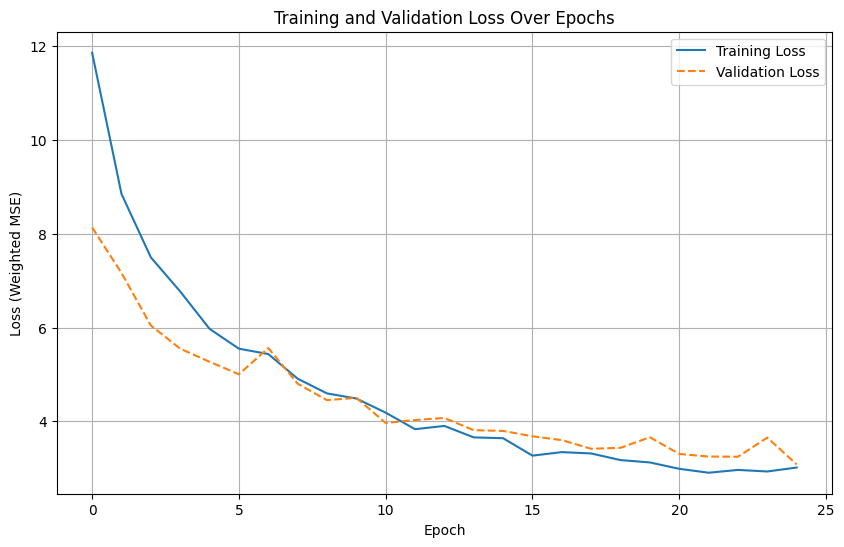

In [169]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss (Weighted MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [175]:
def preprocess_image_for_prediction(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0  # Normalize
    return tf.expand_dims(image, axis=0)  # Add batch dimension
img = preprocess_image_for_prediction("download (3).jpeg")
prediction = model.predict(img)
predicted_score = prediction[0][0]
print(df.loc["Gardevoir"]["Smash Normalized"])

print(f"Predicted Smash Score (0–10 scale): {predicted_score:.2f}")


1/1 [==============================] - 0s 35ms/step
8.821994017921478
Predicted Smash Score (0–10 scale): 2.68
